In [13]:
import tensorflow as tf
import numpy as np
import gym
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from collections import deque

In [2]:
n_outputs = 2

input_ = tf.keras.layers.Input(shape=[4])
dense1 = tf.keras.layers.Dense(32, activation='elu')(input_)
dense2 = tf.keras.layers.Dense(32, activation='elu')(dense1)
state_values = tf.keras.layers.Dense(1)(dense2)
raw_advantages = tf.keras.layers.Dense(n_outputs)(dense2)
advantages = raw_advantages - tf.keras.backend.max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
model = tf.keras.models.Model(inputs=[input_], outputs=[Q_values])

target = tf.keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [3]:
batch_size = 32
discount_rate = 0.95
optimizer = tf.keras.optimizers.Adam(lr=1e-2)
loss_fn = tf.keras.losses.Huber()
replay_memory = deque(maxlen=2000)
env = gym.make("CartPole-v1")

In [4]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [5]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [6]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [7]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [16]:
def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch

In [9]:
rewards = []
best_score = 0

for episode in range(500):
    obs = env.reset()
    for step in range(200):
        epsilon = max(1-episode/500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step > best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(
        episode, step+1, epsilon, end=""))
    if episode > 50:
        training_step(batch_size)
    if episode % 200 == 0:
        target.set_weights(model.get_weights())
        
model.set_weights(best_weights)

Episode: 0, Steps: 12, eps: 1.000
Episode: 1, Steps: 47, eps: 0.998
Episode: 2, Steps: 24, eps: 0.996
Episode: 3, Steps: 17, eps: 0.994
Episode: 4, Steps: 12, eps: 0.992
Episode: 5, Steps: 17, eps: 0.990
Episode: 6, Steps: 14, eps: 0.988
Episode: 7, Steps: 77, eps: 0.986
Episode: 8, Steps: 13, eps: 0.984
Episode: 9, Steps: 14, eps: 0.982
Episode: 10, Steps: 31, eps: 0.980
Episode: 11, Steps: 18, eps: 0.978
Episode: 12, Steps: 28, eps: 0.976
Episode: 13, Steps: 38, eps: 0.974
Episode: 14, Steps: 44, eps: 0.972
Episode: 15, Steps: 16, eps: 0.970
Episode: 16, Steps: 27, eps: 0.968
Episode: 17, Steps: 13, eps: 0.966
Episode: 18, Steps: 25, eps: 0.964
Episode: 19, Steps: 17, eps: 0.962
Episode: 20, Steps: 26, eps: 0.960
Episode: 21, Steps: 16, eps: 0.958
Episode: 22, Steps: 31, eps: 0.956
Episode: 23, Steps: 18, eps: 0.954
Episode: 24, Steps: 34, eps: 0.952
Episode: 25, Steps: 19, eps: 0.950
Episode: 26, Steps: 41, eps: 0.948
Episode: 27, Steps: 18, eps: 0.946
Episode: 28, Steps: 19, eps: 0

Episode: 231, Steps: 21, eps: 0.538
Episode: 232, Steps: 15, eps: 0.536
Episode: 233, Steps: 12, eps: 0.534
Episode: 234, Steps: 13, eps: 0.532
Episode: 235, Steps: 16, eps: 0.530
Episode: 236, Steps: 42, eps: 0.528
Episode: 237, Steps: 55, eps: 0.526
Episode: 238, Steps: 40, eps: 0.524
Episode: 239, Steps: 25, eps: 0.522
Episode: 240, Steps: 30, eps: 0.520
Episode: 241, Steps: 23, eps: 0.518
Episode: 242, Steps: 20, eps: 0.516
Episode: 243, Steps: 52, eps: 0.514
Episode: 244, Steps: 63, eps: 0.512
Episode: 245, Steps: 20, eps: 0.510
Episode: 246, Steps: 27, eps: 0.508
Episode: 247, Steps: 32, eps: 0.506
Episode: 248, Steps: 58, eps: 0.504
Episode: 249, Steps: 41, eps: 0.502
Episode: 250, Steps: 39, eps: 0.500
Episode: 251, Steps: 51, eps: 0.498
Episode: 252, Steps: 93, eps: 0.496
Episode: 253, Steps: 28, eps: 0.494
Episode: 254, Steps: 21, eps: 0.492
Episode: 255, Steps: 15, eps: 0.490
Episode: 256, Steps: 20, eps: 0.488
Episode: 257, Steps: 18, eps: 0.486
Episode: 258, Steps: 10, eps

Episode: 459, Steps: 47, eps: 0.082
Episode: 460, Steps: 44, eps: 0.080
Episode: 461, Steps: 44, eps: 0.078
Episode: 462, Steps: 34, eps: 0.076
Episode: 463, Steps: 34, eps: 0.074
Episode: 464, Steps: 11, eps: 0.072
Episode: 465, Steps: 10, eps: 0.070
Episode: 466, Steps: 9, eps: 0.068
Episode: 467, Steps: 10, eps: 0.066
Episode: 468, Steps: 9, eps: 0.064
Episode: 469, Steps: 11, eps: 0.062
Episode: 470, Steps: 10, eps: 0.060
Episode: 471, Steps: 10, eps: 0.058
Episode: 472, Steps: 10, eps: 0.056
Episode: 473, Steps: 10, eps: 0.054
Episode: 474, Steps: 9, eps: 0.052
Episode: 475, Steps: 8, eps: 0.050
Episode: 476, Steps: 10, eps: 0.048
Episode: 477, Steps: 10, eps: 0.046
Episode: 478, Steps: 9, eps: 0.044
Episode: 479, Steps: 10, eps: 0.042
Episode: 480, Steps: 10, eps: 0.040
Episode: 481, Steps: 10, eps: 0.038
Episode: 482, Steps: 8, eps: 0.036
Episode: 483, Steps: 9, eps: 0.034
Episode: 484, Steps: 10, eps: 0.032
Episode: 485, Steps: 10, eps: 0.030
Episode: 486, Steps: 10, eps: 0.028

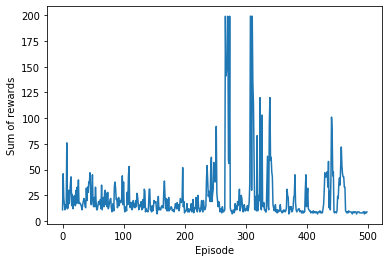

In [10]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.show()

In [17]:
frames = []
state = env.reset()

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)